# Windspeed Analysis for Windfarm
***


Ireland’s abundant wind resources make it an ideal candidate for harnessing wind energy, a key component in the country’s transition to renewable energy. This project focuses on analyzing wind speed data from a specific location in Ireland,  utilizing historical weather data from Met Éireann and other credible sources. By examining trends and patterns in hourly collected wind speed data over different timeframes daily, monthly, and yearly—this analysis aims to assess the potential for wind energy generation near Mace Head in Galway. Additionally, it considers operational factors, such as the minimum and maximum wind speeds at which wind turbines operate, to evaluate the feasibility and efficiency of wind farm operations.

The analysis also delves into long-term trends in wind speeds to assess whether they are consistent or show significant changes over the decades, providing insights into future wind energy potential. Beyond wind speed, other weather metric such as temperature will be explored to understand its impact on wind farm efficiency. This project will also explore the challenges of forecasting wind power output by leveraging available weather predictions and wind turbine power curves. Ultimately, the findings will provide actionable insights for optimizing wind farm development and contribute to Ireland’s renewable energy goals.

## Met Eireann Station

The west coast of Ireland, encompassing counties such as Donegal, Mayo, Galway, and Clare, is the ideal region for wind speed analysis due to its exposure to strong and consistent Atlantic winds, making it one of the most productive areas for wind energy generation. With high average wind speeds year-round and significant potential for both onshore and offshore wind farms, this region offers unparalleled opportunities for efficient and sustainable wind power development. Its proven track record, exemplified by successful projects like the Galway Wind Park, further underscores its suitability as a focal point for wind speed analysis and wind farm optimization [[57]](57).
For this project the county of Galway and more specific the Met Eireann station in Mace Head was chosen to have the wind speed analysed for windfarm as it is one of the few stations in Galway that presents hourly data of some parameters such as the Mean Wind Speed (kt) and Air Temperature (C) since 2003, which will be beneficial for the analysis to be carried out as part of this project.

## Read in data

In this section, the appropriate modules are imported, the data is read in and an analysis is completed to have an overview of the data.

In [86]:
# Import pandas

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import calendar

Looking at the file hly275.csv downloaded from [Met Eireann website](https://www.met.ie/climate/available-data/historical-data) and saved into the project folder is noticeable that there are 17 rows that needs to be removed to allow proper analysis of the data [[58]](58).

In [59]:
# Read in Data and skip rows 17

file = 'hly275.csv'

df = pd.read_csv(file,skiprows=17)

/var/folders/rk/fh00kl713wq4442gfb60yzk40000gn/T/ipykernel_48625/1798932155.py:5: DtypeWarning: Columns (2,4,6,7,8,9,10,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file,skiprows=17)


In [60]:
# Quick look into the first 5 rows

df.head()

,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl,ind.3,wdsp,ind.4,wddir
0,13-aug-2003 01:00,-1,,4,,4,,,,,,7,,7,
1,13-aug-2003 02:00,-1,,4,,4,,,,,,7,,7,
2,13-aug-2003 03:00,-1,,4,,4,,,,,,7,,7,
3,13-aug-2003 04:00,-1,,4,,4,,,,,,7,,7,
4,13-aug-2003 05:00,-1,,4,,4,,,,,,7,,7,


The first 5 rows show a lot of null data including wdsp (mean windspeed). Therefore let's have a look at the number of 'NaN' values in this dataset.

In [61]:
# Confirming the count of Non-null data and data type

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186744 entries, 0 to 186743
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    186744 non-null  object
 1   ind     186744 non-null  int64 
 2   rain    186744 non-null  object
 3   ind.1   186744 non-null  int64 
 4   temp    186744 non-null  object
 5   ind.2   186744 non-null  int64 
 6   wetb    186744 non-null  object
 7   dewpt   186744 non-null  object
 8   vappr   186744 non-null  object
 9   rhum    186744 non-null  object
 10  msl     186744 non-null  object
 11  ind.3   186744 non-null  int64 
 12  wdsp    186744 non-null  object
 13  ind.4   186744 non-null  int64 
 14  wddir   186744 non-null  object
dtypes: int64(5), object(10)
memory usage: 21.4+ MB


From df.info() it does not seem to have null data which goes against what we have just seend in the first 5 rows and that might be due to the data type. Therefore let's check the number of unique values in 'wdsp' column.

In [62]:
# See all unique values in the column 'wdsp'

print(df['wdsp'].unique())  

[' ' '6' '4' '3' '5' '7' '9' '12' '10' '8' '2' '1' '11' '13' '16' '17'
 '19' '22' '25' '23' '14' '18' '20' '21' '15' '24' '26' '30' '28' '29'
 '27' '33' '36' '31' '32' '34' '37' '42' '44' '40' '35' '38' '39' '41'
 '43' '53' '50' '48' '47' '46' '0' '45' '51' '52' '49' '56' '55' 17 18 15
 14 11 6 5 3 4 8 9 12 13 16 7 2 10 20 23 21 22 19 25 26 28 29 27 24 30 1
 31 35 37 34 41 51 55 56 45 40 36 33 32 39 42 38 46 43 47 49 44 50 0 54 48
 52]


From the output of unique values function above is possible to see that the data type in this column is mixed, showing string and numeric data types. Also, there is null data, so let's clean the data.

## Clean the dataset

In this section, we replace and clean null data, then convert all the string data in column 'wdsp' to integer. We also normalise the datetime data to 'YYYY-MM-DD hh:mm:ss'.

### Replace null values

In [63]:
# Replace non-numeric or invalid values with NaN

df['wdsp'] = df['wdsp'].replace([' ', '', 'NA', 'null'], np.nan)

In [64]:
# Count NaN values in 'wdsp'
nan_wdsp_count = df['wdsp'].isnull().sum()

print(f"Number of NaN values in 'wdsp': {nan_wdsp_count}")

Number of NaN values in 'wdsp': 1296


### Change data type

In [65]:
# Convert 'wdsp' to integer, coercing non-convertible values to NaN

df['wdsp'] = pd.to_numeric(df['wdsp'], errors='coerce').astype('Int64') 

# Verify the data types

print(df['wdsp'].dtypes)

Int64


In [66]:
# Check the first few rows for 'date' and 'wdsp' columns

print(df[['date', 'wdsp']].head())

                date  wdsp
0  13-aug-2003 01:00  <NA>
1  13-aug-2003 02:00  <NA>
2  13-aug-2003 03:00  <NA>
3  13-aug-2003 04:00  <NA>
4  13-aug-2003 05:00  <NA>


### Drop NaN

In [67]:
# Drop rows where 'wdsp' is NaN
df = df.dropna(subset=['wdsp'])

# Verify if NaN values are removed
null_wdsp_count = df['wdsp'].isna().sum()
print(f"Number of NaN values in 'wdsp' after dropping: {null_wdsp_count}")

Number of NaN values in 'wdsp' after dropping: 0


### Normalise datetime

In [69]:
# Change date time format

df['date'] = pd.to_datetime(df['date'], format='%d-%b-%Y %H:%M')

df['date']

24       2003-08-14 01:00:00
25       2003-08-14 02:00:00
26       2003-08-14 03:00:00
27       2003-08-14 04:00:00
28       2003-08-14 05:00:00
                 ...        
186739   2024-11-30 20:00:00
186740   2024-11-30 21:00:00
186741   2024-11-30 22:00:00
186742   2024-11-30 23:00:00
186743   2024-12-01 00:00:00
Name: date, Length: 185448, dtype: datetime64[ns]

Note: the column 'date' contains Date and Time in UTC time zone, so no further action required here.

## Wind power in Mace Head - Galway

In County Galway, wind turbines such as the Siemens Gamesa SWT-3.0-101, Vestas V52, and Nordex N149 are the three most commonly used in wind farms, accounting for 150 out of 192 turbines currently confirmed as operational [[59]](59). In the table below is possible to see the specification for most used turbines in Galway [[60]](60) [[61]](61) [[62]](62) [[63]](63). These specifications ensure efficient operation in Galway's moderate to strong wind conditions.

| **Wind Turbine Model**     | **Cut-in Wind Speed** | **Rated Wind Speed** | **Cut-out Wind Speed** |**Number of Turbines in Galway** |**Rated Power** |
|----------------------------|-----------------------|----------------------|------------------------|---------------------------------|----------------|
| **Vestas V52**              | 4.0 m/s               | 14 m/s               | 25.0 m/s               |70                               |0.85 MW         |
| **Siemens SWT-3.0-101**     | 3.5 m/s               | 14.5 m/s             | 25 m/s                 |58                               |3.0 MW          |
| **Nordex N149 4.0-4.5**     | 3.0 m/s               | 12 m/s               | 20 m/s                 |15                               |4.0 MW          |
| **Nordex N149 5.0**         | 3.0 m/s               | 12.5 m/s             | 26 m/s                 |7                                |5.0 MW          |

To calculate the optimum cut-in, rated and cut-out wind speed weighted average was used considered the amount of turbines for each model. The results were:
```bash
Optimum Cut-in Wind Speed: 3.66 m/s
Optimum Rated Wind Speed: 13.92 m/s
Optimum Cut-out Wind Speed: 24.55 m/s
```

In [77]:
# Calculate Mean Wind Speed by Hour
df['hour'] = df['date'].dt.hour
hourly_mean_wind = df.groupby('hour')['wdsp'].mean()

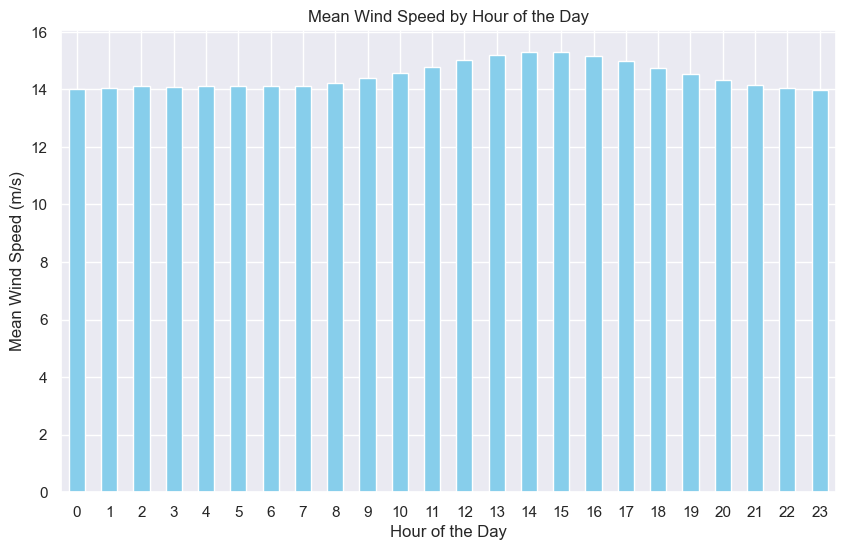

In [82]:
# Set the plot style
sns.set(style="darkgrid")

# Hourly Mean Wind Speed Plot
plt.figure(figsize=(10,6))
hourly_mean_wind.plot(kind='bar', color='skyblue')
plt.title('Mean Wind Speed by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Wind Speed (m/s)')
plt.xticks(rotation=0)
plt.show()

In [78]:
# Calculate Mean Wind Speed by Day
df['date_day'] = df['date'].dt.date
daily_mean_wind = df.groupby('date_day')['wdsp'].mean()

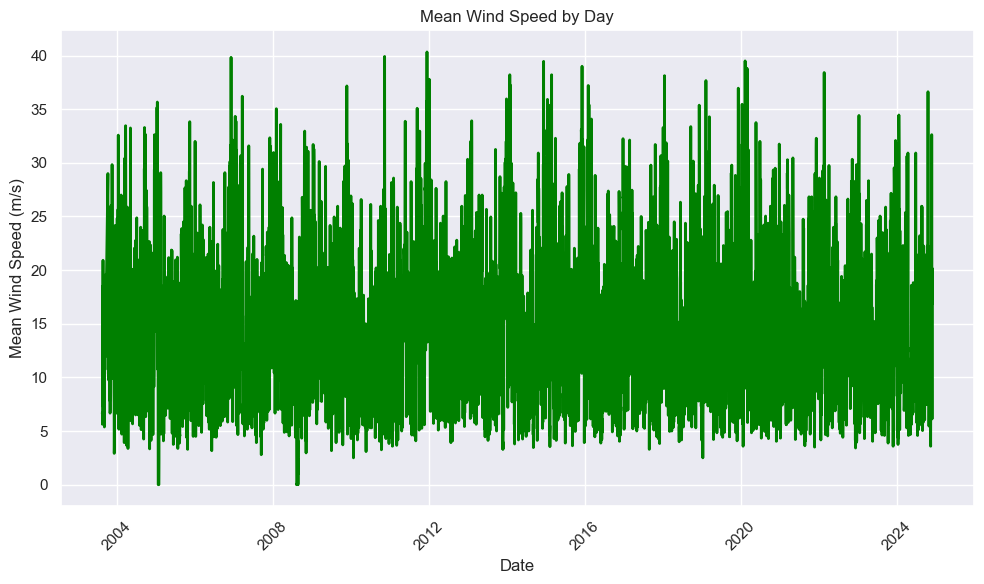

In [83]:
# Daily Mean Wind Speed Plot
plt.figure(figsize=(10,6))
daily_mean_wind.plot(kind='line', color='green', lw=2)
plt.title('Mean Wind Speed by Day')
plt.xlabel('Date')
plt.ylabel('Mean Wind Speed (m/s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [80]:
# Calculate Mean Wind Speed by Month
df['month'] = df['date'].dt.month
monthly_mean_wind = df.groupby('month')['wdsp'].mean()

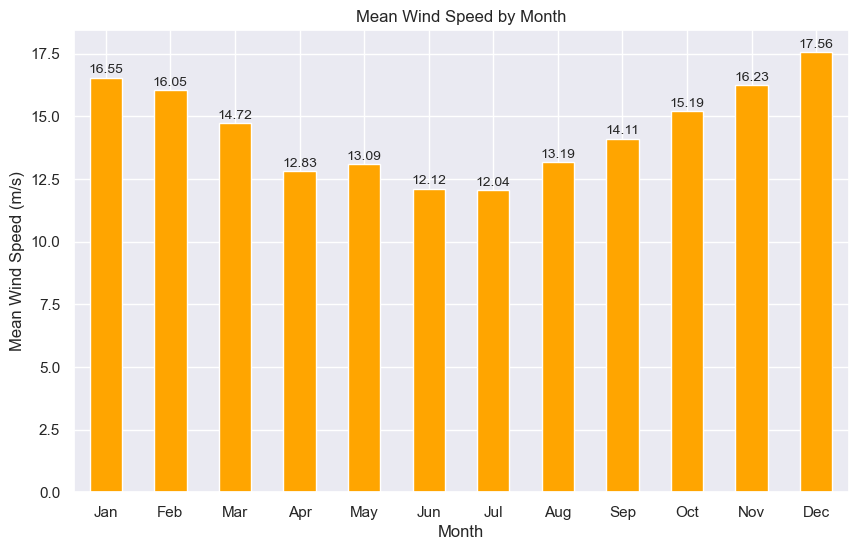

In [90]:
# Monthly Mean Wind Speed Plot with Month Names
plt.figure(figsize=(10,6))
monthly_mean_wind.plot(kind='bar', color='orange')

# Setting the x-ticks to the abbreviated month names
plt.xticks(ticks=range(0, 12), labels=[calendar.month_abbr[i] for i in range(1, 13)], rotation=0)

# Adding bar labels
for i, value in enumerate(monthly_mean_wind):
    plt.text(i, value + 0.05, f'{value:.2f}', ha='center', va='bottom', fontsize=10)

# Adding title and labels
plt.title('Mean Wind Speed by Month')
plt.xlabel('Month')
plt.ylabel('Mean Wind Speed (m/s)')
plt.show()

In [81]:
# Calculate Mean Wind Speed by Year
df['year'] = df['date'].dt.year
yearly_mean_wind = df.groupby('year')['wdsp'].mean()

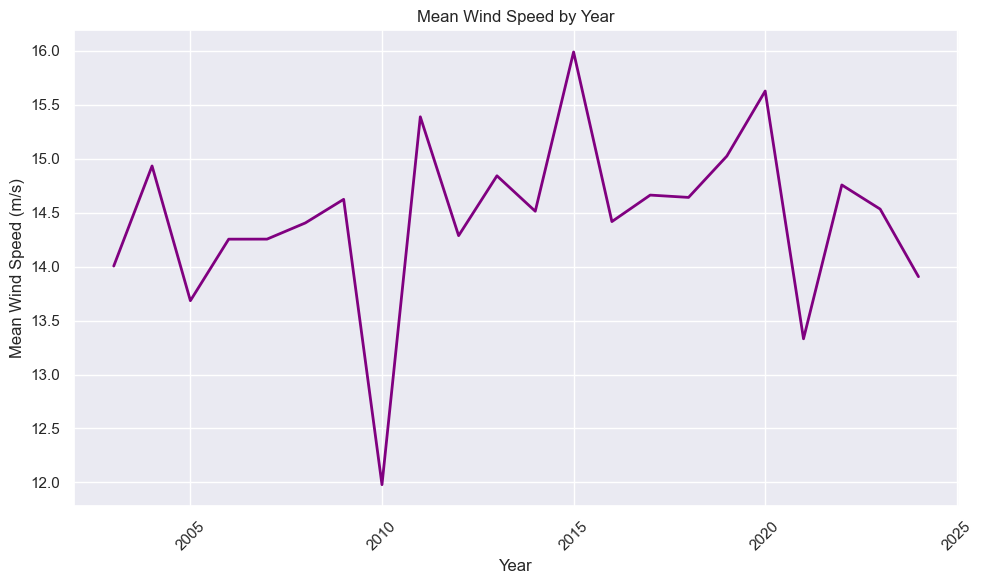

In [85]:
# Yearly Mean Wind Speed Plot
plt.figure(figsize=(10,6))
yearly_mean_wind.plot(kind='line', color='purple', lw=2)
plt.title('Mean Wind Speed by Year')
plt.xlabel('Year')
plt.ylabel('Mean Wind Speed (m/s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

***
# End